## Overview

Figures are generated.

In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
from scipy.stats import genextreme, pearson3
from scipy.optimize import curve_fit
from scipy.stats import genextreme as gev
from scipy.stats import pearson3
from sklearn.preprocessing import StandardScaler
import spei as si

# Directory to pywrdrb project
pywrdrb_directory = '../Pywr-DRB/'
sys.path.append(pywrdrb_directory)

from pywrdrb.pywr_drb_node_data import obs_pub_site_matches

In [5]:
Q_reconst = pd.read_csv(f'./outputs/historic_reconstruction_daily_1960_2022_nhmv10_mgd.csv', sep = ',', index_col = 0, parse_dates = True)

# Sum inflows by node
Q_reconst_nodes = pd.DataFrame(index=Q_reconst.index, columns=obs_pub_site_matches.keys())
for node in Q_reconst_nodes.columns:
    if obs_pub_site_matches[node] is not None:
        Q_reconst_nodes.loc[:,node] = Q_reconst.loc[:, obs_pub_site_matches[node]].sum(axis=1)
    else:
        Q_reconst_nodes.loc[:,node] = Q_reconst.loc[:, node]
Q_reconst_nodes["Total"] = Q_reconst_nodes.sum(axis=1)

## Flow distributions

- Is an HMM suitable? 

## Drought metrics

Starting with SSI.


In [4]:
# Rolling sum
Q_rsum = Q_reconst.rolling("180D").sum().dropna()
Q_nodes_rsum = Q_reconst_nodes.rolling("180D").sum().dropna()

node_ssi = pd.DataFrame(index = Q_rsum.index, columns=Q_nodes_rsum.columns)
for node in node_ssi.columns:
    node_ssi[node] = si.ssfi(Q_nodes_rsum[node], dist = scs.gamma)
    

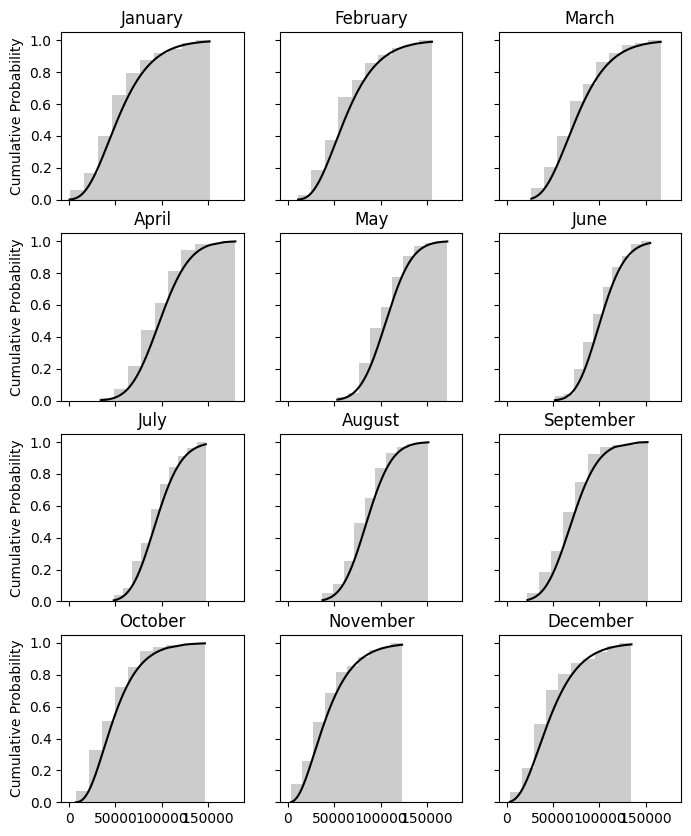

In [5]:
cannonsville_gammfit_plot = si.plot.dist(Q_nodes_rsum['cannonsville'], scs.gamma, cumulative=True, legend = False)

In [6]:
def plot_ssi(ssi, bound = 3.0, figsize= (8, 4), ax = None, gradient = False):
    """Plot the standardized index values as a time series. 
    Modified from https://github.com/martinvonk/SPEI/blob/main/src/spei/plot.py

    Parameters
    ----------
    si : pandas.Series
        Series of the standardized index
    bound : int, optional
        Maximum and minimum ylim of plot
    figsize : tuple, optional
        Figure size, by default (8, 4)
    ax : matplotlib.Axes, optional
        Axes handle, by default None which create a new axes

    Returns
    -------
    matplotlib.Axes
        Axes handle
    """
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    ax.plot(ssi, color="k", lw = 1, label="SSI")
    ax.axhline(0, linestyle="--", color="k")

    nmin = -bound
    nmax = bound
    # Classify droughts
    droughts = np.zeros_like(ssi.values)
    drought_days = []
    drought_counter = 0
    for ind in range(len(droughts)):
        if ssi.values[ind] <= -1:
            drought_days.append(ind)
            drought_counter += 1
            if (drought_counter > 0) and (ssi.values[ind] <= -2):
                droughts[drought_days] = 1
        else:
            drought_days = [] 
            drought_counter = 0
        
    if gradient:
        droughts = ssi.to_numpy(dtype=float, copy=True)
        droughts[droughts > 0] = 0
        nodroughts = ssi.to_numpy(dtype=float, copy=True)
        nodroughts[nodroughts < 0] = 0
        x, y = np.meshgrid(ssi.index, np.linspace(nmin, nmax, 100))
        ax.contourf(
            x, y, y, cmap=plt.get_cmap("seismic_r"), levels=np.linspace(nmin, nmax, 100)
        )
        ax.fill_between(x=ssi.index, y1=droughts, y2=nmin, color="w")
        ax.fill_between(x=ssi.index, y1=nodroughts, y2=nmax, color="w")
    else:
        ax.fill_between(x=ssi.index, y1=nmax, y2=nmin, where=(droughts>0), color='red', alpha=0.5, interpolate=False, label = 'Drought Period')
    ax.set_ylim(nmin, nmax)
    return ax

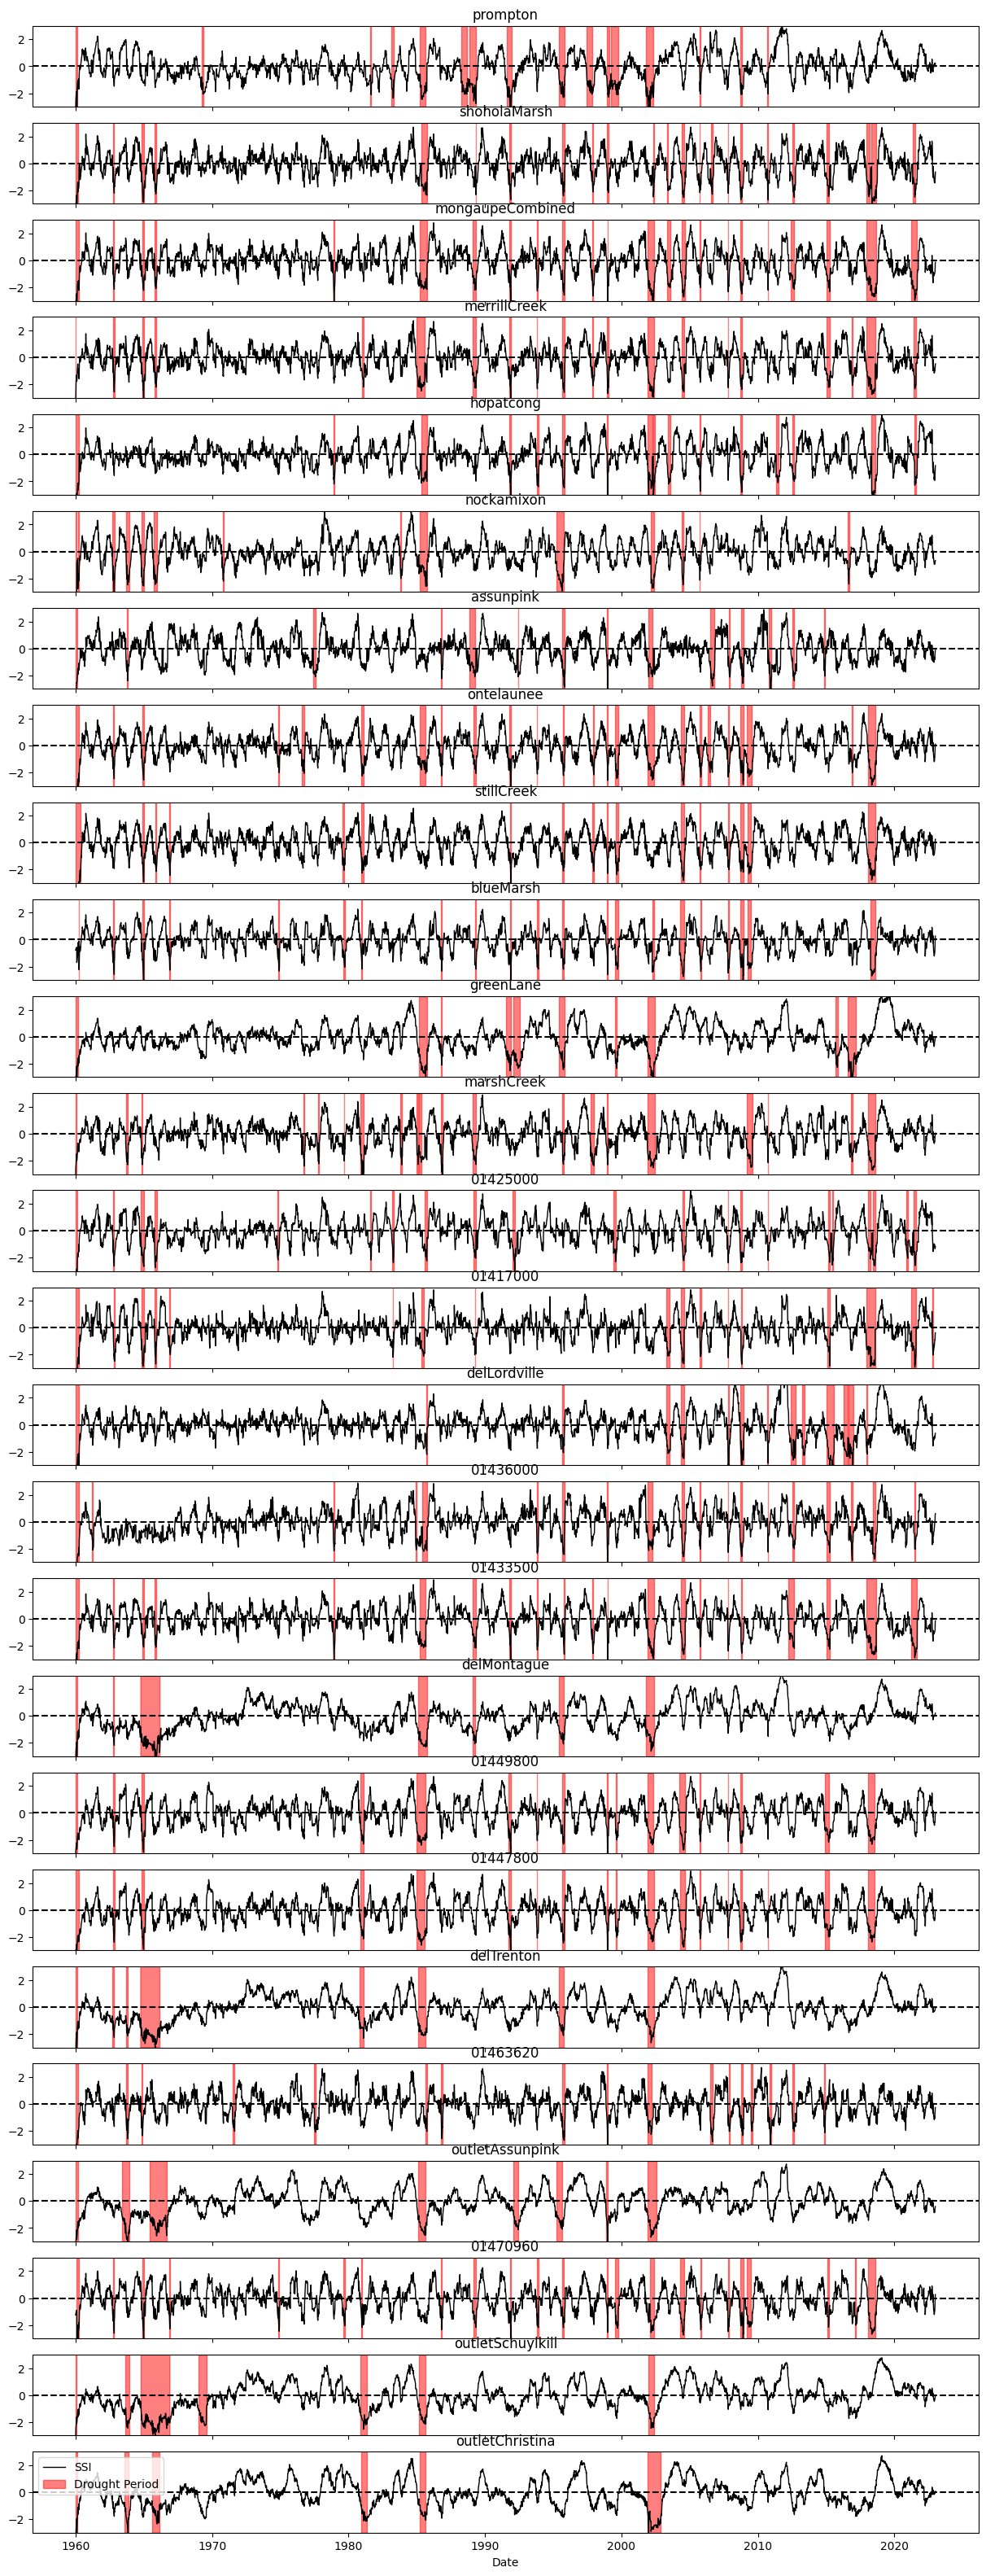

In [127]:
plot_nodes = ['prompton', 'shoholaMarsh', 'mongaupeCombined', 'merrillCreek', 
              'hopatcong', 'nockamixon', 'assunpink', 'ontelaunee', 'stillCreek',
              'blueMarsh', 'greenLane', 'marshCreek', '01425000', '01417000', 
              'delLordville', '01436000', '01433500', 'delMontague', '01449800',
              '01447800', 'delTrenton', '01463620', 'outletAssunpink',
              '01470960', 'outletSchuylkill','outletChristina']

plot_nodes = ['cannonsville', 'pepacton', 'neversink', 'fewalter', 'beltzvilleCombined']

fig, axs = plt.subplots(nrows=len(plot_nodes), ncols=1, figsize = (15,40), sharex = True)

for i,ax in enumerate(axs):
    node = plot_nodes[i]
    plot_ssi(node_ssi[node], ax = ax)
    ax.set_title(node)
plt.xlabel('Date')
plt.legend()

In [7]:
node_ssi.to_csv(f'./outputs/ssi_historic_reconstruction_nodes_1960_2022.csv', sep = ',')